In [ ]:
# Step 2. Importing Country Relationships CSV 
import pandas as pd

# Correct path to the CSV file
df_rel = pd.read_csv("/Users/javieraquezada/Desktop/20th-century/Data/20th_century_country_relationships.csv")

# Preview the first rows
print(df_rel.head())

    source      target  value
0  Austria     Germany     10
1  Belgium      France      5
2  Belgium  Luxembourg      3
3  Denmark      Norway     12
4  Denmark      Poland      5


In [9]:
#Step 3. Creating a Network Object from the countries relationships dataframe
import networkx as nx

# Creating a weighted graph object from the dataframe
G = nx.from_pandas_edgelist(
    df_rel,
    source="source",
    target="target",
    edge_attr="value",   # use 'value' as weight
    create_using=nx.Graph()  # undirected graph
)

# Print basic info
print(nx.info(G))

AttributeError: module 'networkx' has no attribute 'info'

In [10]:
# Fixing Error

# Basic info about the graph
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Preview edges with weights
print("Sample edges with weights:")
for edge in list(G.edges(data=True))[:10]:
    print(edge)

Number of nodes: 17
Number of edges: 21
Sample edges with weights:
('Austria', 'Germany', {'value': 10})
('Germany', 'Estonia', {'value': 5})
('Germany', 'Finland', {'value': 4})
('Germany', 'France', {'value': 6})
('Germany', 'Italy', {'value': 8})
('Germany', 'Netherlands', {'value': 5})
('Germany', 'Poland', {'value': 17})
('Germany', 'Russia', {'value': 16})
('Germany', 'Sweden', {'value': 6})
('Germany', 'Ukraine', {'value': 9})


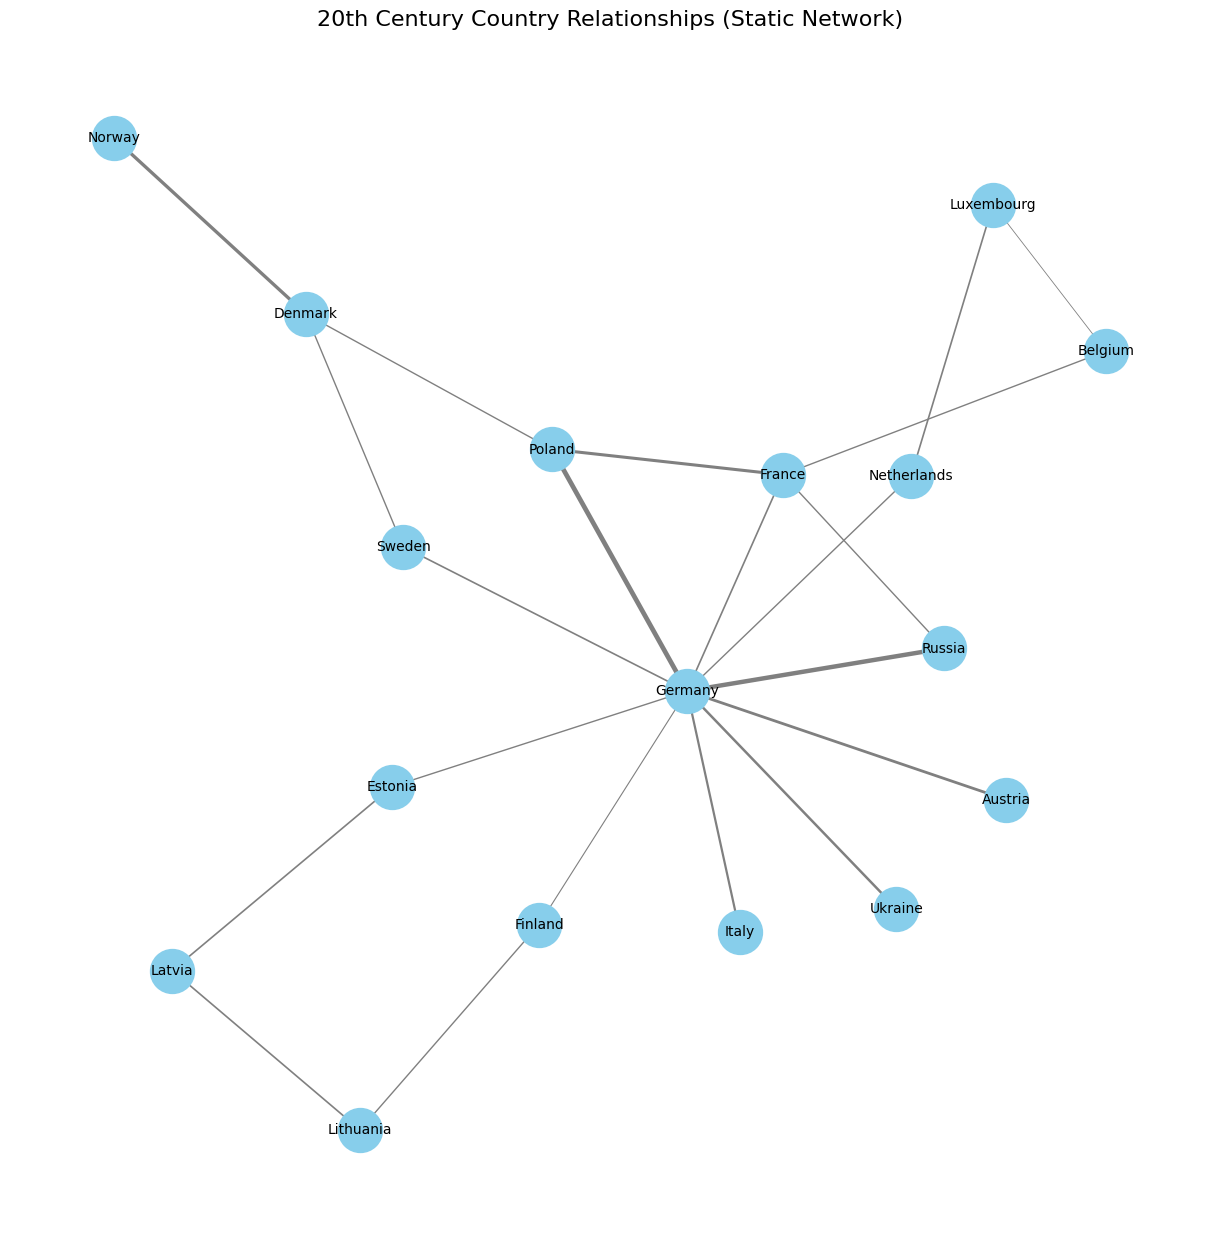

In [11]:
# Step 4. Creating a Static Network graph using only NetworkX 
import matplotlib.pyplot as plt
import networkx as nx

# Creating layout for visualization
pos = nx.kamada_kawai_layout(G)  # positions for all nodes

plt.figure(figsize=(12, 12))
nx.draw(
    G,
    pos,
    with_labels=True,
    node_color='skyblue',
    edge_color='gray',
    width=[d['value']*0.2 for (u, v, d) in G.edges(data=True)],  # edge thickness based on 'value'
    node_size=1000,
    font_size=10
)
plt.title("20th Century Country Relationships (Static Network)", fontsize=16)
plt.show()

Experimenting with Chat GPT suggestions.

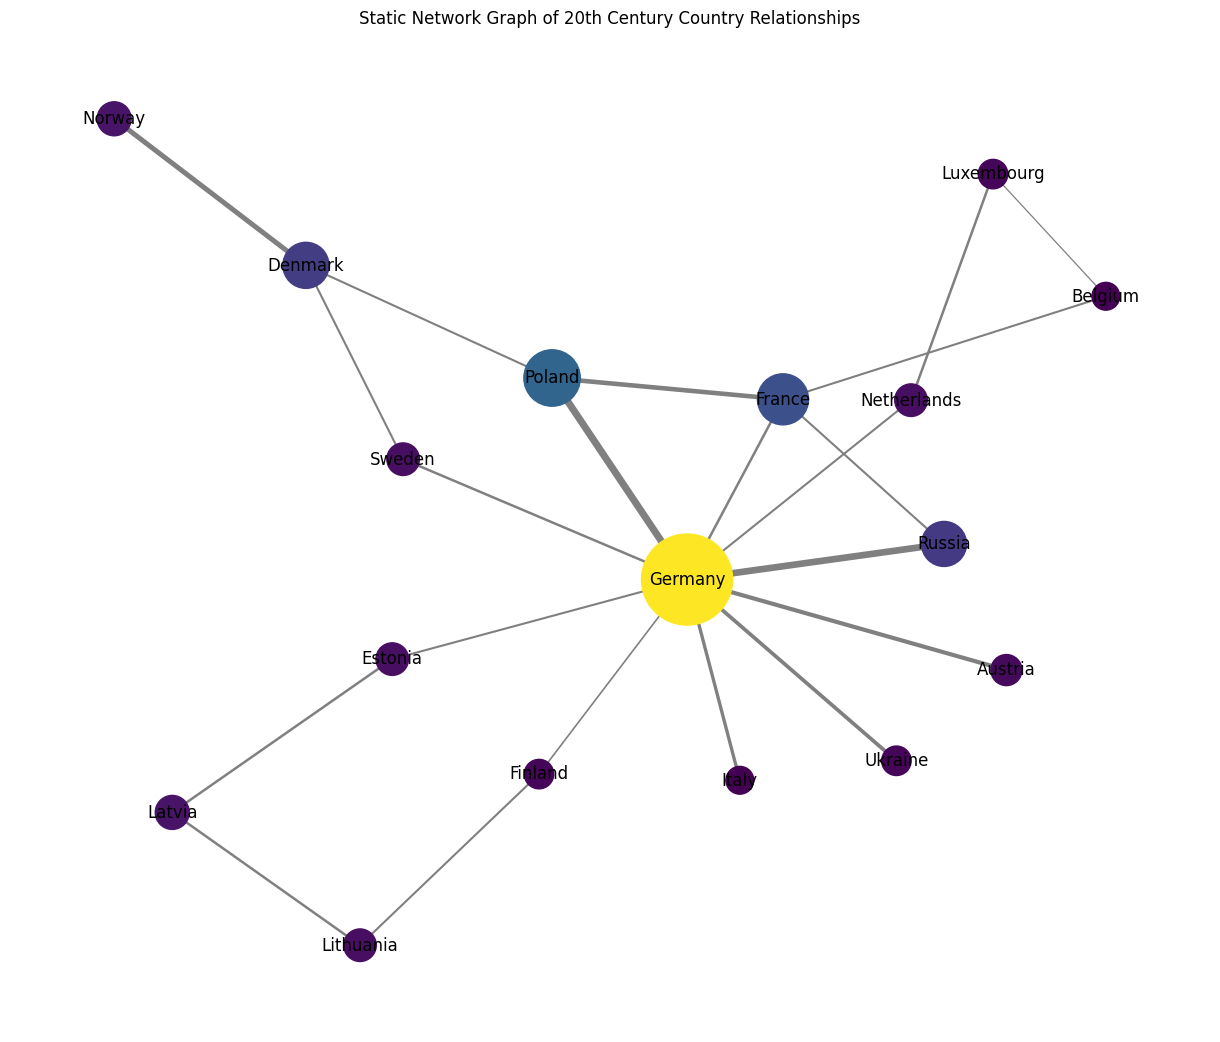

In [12]:
# Experimenting with Chat GPT
import matplotlib.pyplot as plt
import networkx as nx

# Computing node degree (number of connections)
node_degree = dict(G.degree(weight='value'))

# Create node sizes and colors based on degree
node_sizes = [v * 50 for v in node_degree.values()]  # scale factor for visibility
node_colors = [v for v in node_degree.values()]

# Layout
pos = nx.kamada_kawai_layout(G)

# Draw the graph
plt.figure(figsize=(12, 10))
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.viridis,
    edge_color='gray',
    width=[d['value']*0.3 for (u,v,d) in G.edges(data=True)]  # edge thickness
)
plt.title("Static Network Graph of 20th Century Country Relationships")
plt.show()

In [ ]:
# 	Node size grows with the number of connections.
#	Node color reflects degree (darker = more connections).
#	Edge thickness reflects the value column (strength of relationship).


In [13]:
# Step 5. Switching to pyvis, building and interactive network graph from the network object. As HTML
\
from pyvis.network import Network

# Create a Pyvis network object
net = Network(notebook=True, width="1000px", height="800px", 
              bgcolor="#222222", font_color="white", cdn_resources='in_line')

# Set node size based on degree
node_degree = dict(G.degree(weight='value'))
nx.set_node_attributes(G, node_degree, "size")

# Load the NetworkX graph into pyvis
net.from_nx(G)

# Optional: add physics and interactivity
net.show_buttons(filter_=['physics'])
net.repulsion(node_distance=200, central_gravity=0.3)

# Save and show the interactive graph as HTML
net.show("20th_century_countries.html")

20th_century_countries.html


In [20]:
# Step 6. Applying the Leiden algorithm to detect any communities withing the countries.
from cdlib import algorithms

# Apply Leiden algorithm on the NetworkX graph
coms = algorithms.leiden(G)

# Convert community object to a dictionary: {country: community_number}
country_communities = coms.to_node_community_map()
dict_com = {k: v[0] for k, v in country_communities.items()}

# Check the output
print(dict_com)

{'Austria': 0, 'Germany': 0, 'France': 0, 'Poland': 0, 'Russia': 0, 'Italy': 0, 'Ukraine': 0, 'Estonia': 1, 'Latvia': 1, 'Finland': 1, 'Lithuania': 1, 'Belgium': 2, 'Luxembourg': 2, 'Netherlands': 2, 'Denmark': 3, 'Norway': 3, 'Sweden': 3}


In [8]:
#Community 0: Austria, Germany, France, Poland, Russia, Italy, Ukraine
#Community 1: Estonia, Latvia, Finland, Lithuania
#Community 2: Belgium, Luxembourg, Netherlands
#Community 3: Denmark, Norway, Sweden

In [ ]:
#Saving as HTML
# from pyvis.network import Network

# Create interactive network
net_comm = Network(notebook=True, height="700px", width="100%", bgcolor="#222222", font_color="white")

# Add nodes colored by community
for node, comm in dict_com.items():
    color = f"#{hash(comm) & 0xFFFFFF:06x}"
    net_comm.add_node(node, title=node, color=color)

# Add edges with weights
for source, target, data in G.edges(data=True):
    net_comm.add_edge(source, target, value=data['value'])

# Save HTML
net_comm.write_html("20th_century_countries_communities.html")
print("HTML saved: 20th_century_countries_communities.html")

HTML saved: 20th_century_countries_communities.html


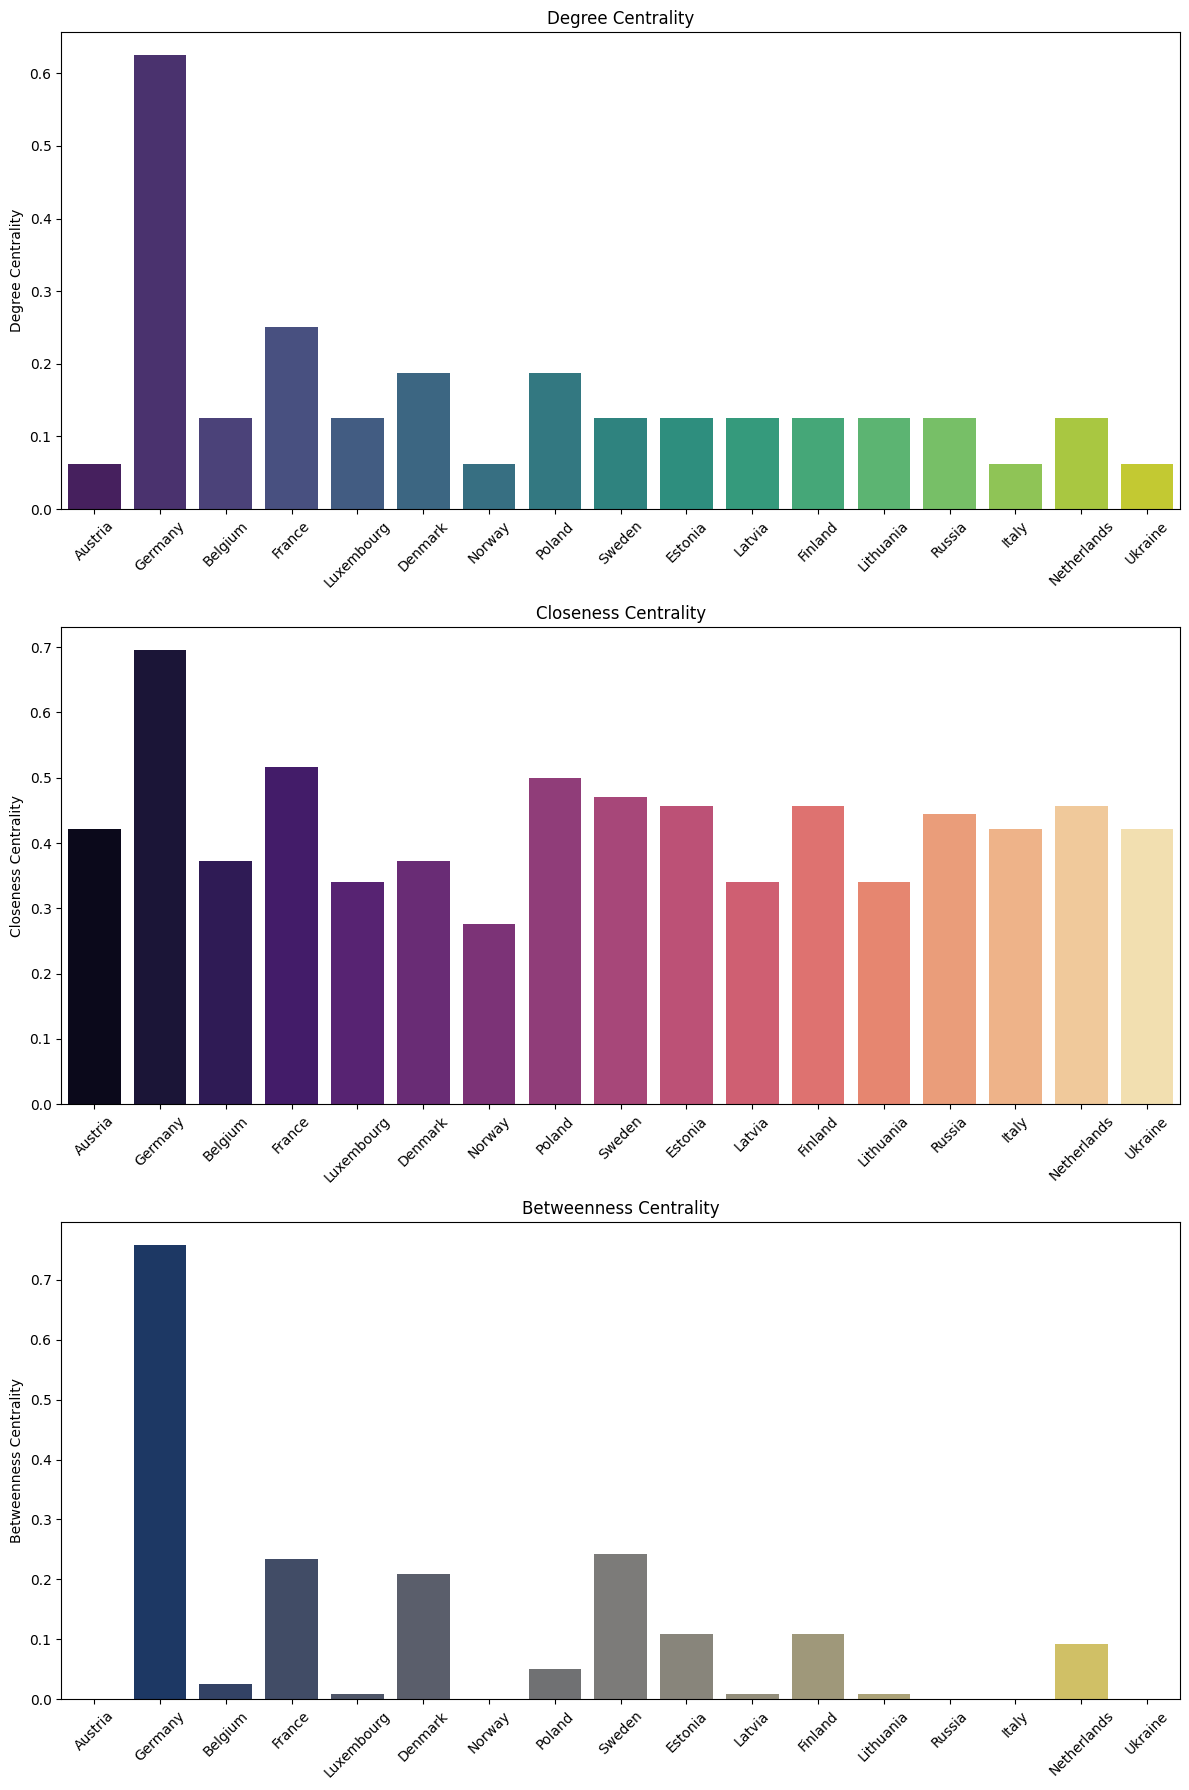

In [ ]:
# Step 7. Visualizing the output of the communities algotithm on a new network graph
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Degree centrality
degree_dict = nx.degree_centrality(G)
# Closeness centrality
closeness_dict = nx.closeness_centrality(G)
# Betweenness centrality
betweenness_dict = nx.betweenness_centrality(G, weight='value')

# Convert to DataFrames for plotting
degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['Degree'])
closeness_df = pd.DataFrame.from_dict(closeness_dict, orient='index', columns=['Closeness'])
betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient='index', columns=['Betweenness'])

# Plotting
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

sns.barplot(x=degree_df.index, y='Degree', data=degree_df, ax=axes[0], palette='viridis')
axes[0].set_title("Degree Centrality")
axes[0].set_ylabel("Degree Centrality")
axes[0].set_xticklabels(degree_df.index, rotation=45)

sns.barplot(x=closeness_df.index, y='Closeness', data=closeness_df, ax=axes[1], palette='magma')
axes[1].set_title("Closeness Centrality")
axes[1].set_ylabel("Closeness Centrality")
axes[1].set_xticklabels(closeness_df.index, rotation=45)

sns.barplot(x=betweenness_df.index, y='Betweenness', data=betweenness_df, ax=axes[2], palette='cividis')
axes[2].set_title("Betweenness Centrality")
axes[2].set_ylabel("Betweenness Centrality")
axes[2].set_xticklabels(betweenness_df.index, rotation=45)

plt.tight_layout()
plt.show()

Analysis Degree Centrality Bar Chart

In [ ]:
# Degree Centrality 
#measures how many direct connections (edges) a node (in our case, a country) has in the network.
#High degree centrality → the country is directly connected to many other countries.
#Low degree centrality → the country has few direct connections.

#In historical terms, it shows which countries were most “connected” or influential in terms of direct
# relationships or interactions during the 20th century.

# In this case it is shown that the countries with highest dregree centrality are Germany and France,
# making sense with their implications in wars. Followed by Denmark and Poland.
# Italy, Norway and Ukraine had the lowest degree refrecting fewer direct conections and limited international reactions 
# during the century.

Analysis Closeness Centrality Bar chart

In [ ]:
# Closeness Centrality 
# measures how close is a node to all the other nodes in the network
# A country with high closeness centrality can reach other countries quickly, indicating strong influence or strategic positioning.
# Mathematically, it’s the inverse of the sum of shortest path distances from that node to all others.

# In this case Germany, France, Poland and Denmark have the highest closeness, meaning they can be " Strategically central" in the network
# High closeness suggests the country could interact or influence others more efficiently.
# The lowest closeness centrality countries are Norway, Lithuania, Latvia, and Luxembourg. Being harder for them reach others quickly.

Analysis Betweennes Centrality Bar Chart

In [ ]:
# Betweenness centrality 
# measures how often a node lies on the shortest paths between other nodes.
# Countries with high betweenness act as bridges or intermediaries between clusters.
# They control the flow of information or influence within the network.

# In this case Germany is the higher and key connector between groups. This shows strategic importance. 
# They control pathways in the network.
# The countries with the lowest Betweenness centrality are Russia, Italy and Ukraine, meaning that their removal would have a minimal 
# effect on conectivity.

Experimenting with Chat GPT suggestions of Upgrade.

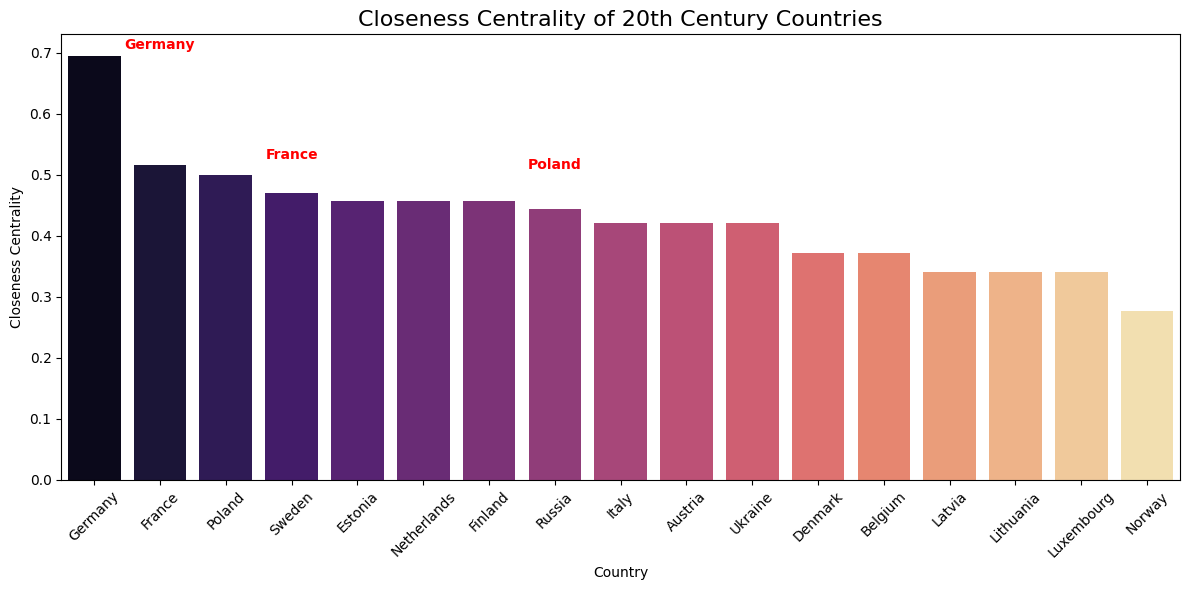

In [ ]:
# Upgrading  Graphs

#Closeness Centrality Bar Chart Upgrade

# Calculating closeness centrality
closeness_dict = nx.closeness_centrality(G)

# Converting to DataFrame for plotting
closeness_df = pd.DataFrame(list(closeness_dict.items()), columns=['Country', 'Closeness'])
closeness_df = closeness_df.sort_values(by='Closeness', ascending=False)

# Plotting
plt.figure(figsize=(12,6))
sns.barplot(data=closeness_df, x='Country', y='Closeness', palette='magma')
plt.title("Closeness Centrality of 20th Century Countries", fontsize=16)
plt.xlabel("Country")
plt.ylabel("Closeness Centrality")
plt.xticks(rotation=45)

# Highlighting top 3 most central countries
for i, row in closeness_df.head(3).iterrows():
    plt.text(i, row['Closeness'] + 0.01, f"{row['Country']}", color='red', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

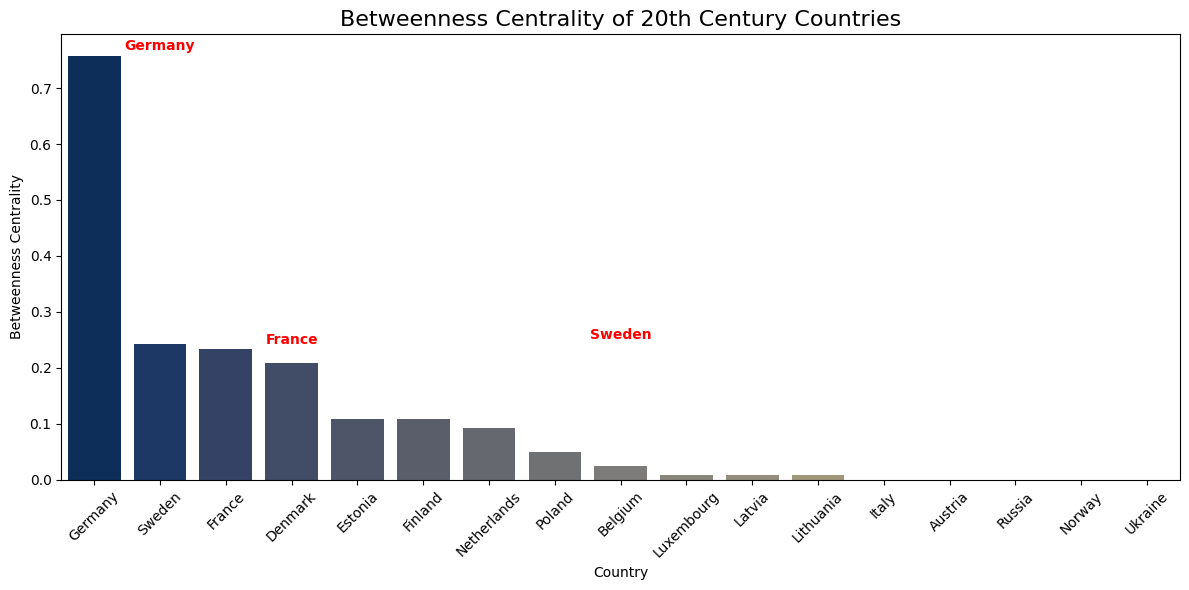

In [ ]:
# Betweennes Centrality Bar Chart Upgrade

# Calculating betweenness centrality
betweenness_dict = nx.betweenness_centrality(G, weight='value')

# Converting to DataFrame for plotting
betweenness_df = pd.DataFrame(list(betweenness_dict.items()), columns=['Country', 'Betweenness'])
betweenness_df = betweenness_df.sort_values(by='Betweenness', ascending=False)

# Plotting
plt.figure(figsize=(12,6))
sns.barplot(data=betweenness_df, x='Country', y='Betweenness', palette='cividis')
plt.title("Betweenness Centrality of 20th Century Countries", fontsize=16)
plt.xlabel("Country")
plt.ylabel("Betweenness Centrality")
plt.xticks(rotation=45)

# Highlighting top 3 most central countries
for i, row in betweenness_df.head(3).iterrows():
    plt.text(i, row['Betweenness'] + 0.01, f"{row['Country']}", color='red', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

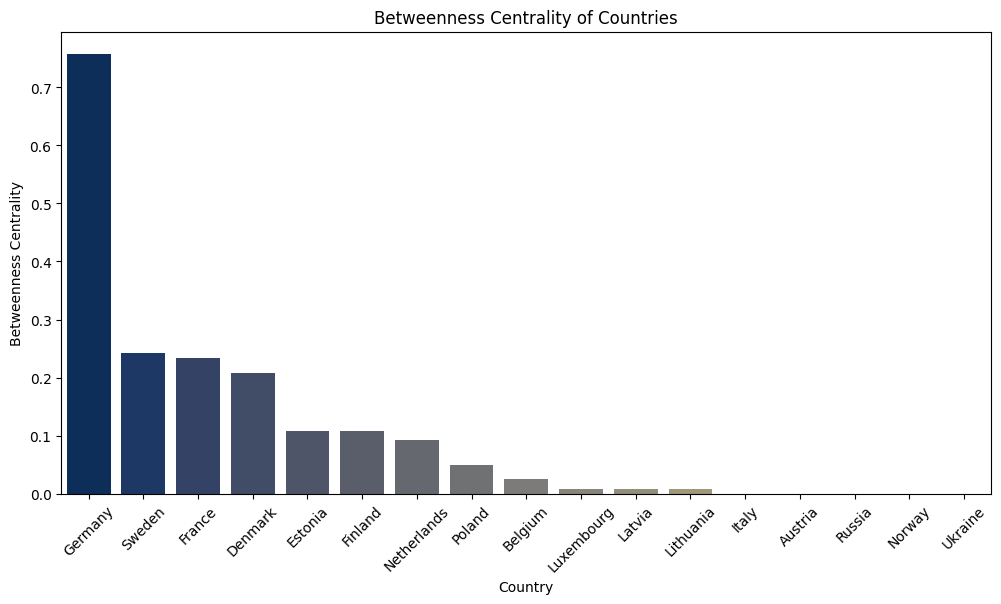

In [ ]:
# Calculating Betweenness Centrality

betweenness_dict = nx.betweenness_centrality(G, weight='value')
betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient='index', columns=['Betweenness'])
betweenness_df = betweenness_df.sort_values(by='Betweenness', ascending=False)

# Plot Betweenness Centrality
plt.figure(figsize=(12,6))
sns.barplot(x=betweenness_df.index, y='Betweenness', data=betweenness_df, palette='cividis')
plt.title("Betweenness Centrality of Countries")
plt.xticks(rotation=45)
plt.ylabel("Betweenness Centrality")
plt.xlabel("Country")
plt.show()